<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Logistic Regression Lab


---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score

## Load the college admissions data

---

To illustrate how to apply logistic regression, we will be using some basic college admissions data. The data only has a few columns:
- `admit`: a binary 1-0 variable indicating whether a student was admitted
- `gre`: the student's GRE score
- `gpa`: the student's GPA
- `prestige`: a rating for the "prestige" of the college

In [3]:
admissions = pd.read_csv(
    '../../../../../resource-datasets/admissions/admissions.csv')

In [4]:
admissions.head()

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


## Clean the data

In [5]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
admit       400 non-null int64
gre         398 non-null float64
gpa         398 non-null float64
prestige    399 non-null float64
dtypes: float64(3), int64(1)
memory usage: 12.6 KB


In [6]:
admissions.dropna(inplace=True)

In [7]:
admissions.shape

(397, 4)

In [8]:
# baseline
admissions.admit.value_counts(normalize=True).max()

0.6826196473551638

### What are the probabilities of admittance by prestige?

In [9]:
admissions.groupby('prestige')[['admit']].mean()

,admit
prestige,
1.0,0.540984
2.0,0.358108
3.0,0.231405
4.0,0.179104


### Write a function to calculate odds and calculate the odds of admittance by prestige.

In [10]:
def odds(p):
    return p / (1 - p)

In [11]:
admissions.groupby('prestige')[['admit']].mean().apply(odds)

,admit
prestige,
1.0,1.178571
2.0,0.557895
3.0,0.301075
4.0,0.218182


### Split into predictor data and target variable, dummify the prestige columns and standardize your predictors

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [13]:
X = admissions.copy()
X = pd.get_dummies(X, columns=['prestige'], drop_first=True)
y = X.pop('admit')
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

### Take only the dummified prestige columns as predictors and fit a logistic regression model

- How do you interpret the model coefficients in this case?
- What are the predicted probabilities for the different observations? Compare to the admission probabilities for different prestige levels calculated above. 
- Make sure to set the regularization strength to a very large value. 
- Use `solver='newton-cg'`.

In [14]:
prestige_columns = [col for col in X.columns if 'prestige' in col]
model = LogisticRegression(C=10**10, solver='newton-cg', 
                           max_iter=10000, tol=10**(-8))
model.fit(X[prestige_columns], y)
model.score(X[prestige_columns], y)

0.6952141057934509

In [15]:
model.intercept_, model.coef_

(array([-0.81510947]), array([[-0.36164012, -0.62819328, -0.63175593]]))

In [16]:
for prestige in np.sort(admissions.prestige.unique()):
    print(prestige, model.predict_proba(X[prestige_columns])[admissions.prestige==prestige][0])

1.0 [0.45901639 0.54098361]
2.0 [0.64189189 0.35810811]
3.0 [0.76859504 0.23140496]
4.0 [0.82089552 0.17910448]


### Use LogisticRegressionCV to tune your model

Test for both penalties. Which one leads to better results? Compare the model coefficients for the best respective models.

In [17]:
model_cv = LogisticRegressionCV(Cs=np.logspace(-4, 4, 20), 
                                solver='lbfgs', penalty='l2', cv=5)
model_cv.fit(X, y)
model_cv.score(X, y)

0.707808564231738

In [18]:
model = LogisticRegression(C=model_cv.C_[0], penalty='l2', solver='lbfgs')
model.fit(X, y)
cross_val_score(model, X, y, cv=5).mean()

0.702766057196437

In [19]:
model.coef_

array([[ 0.25541571,  0.29366118, -0.31434862, -0.59962766, -0.56663084]])

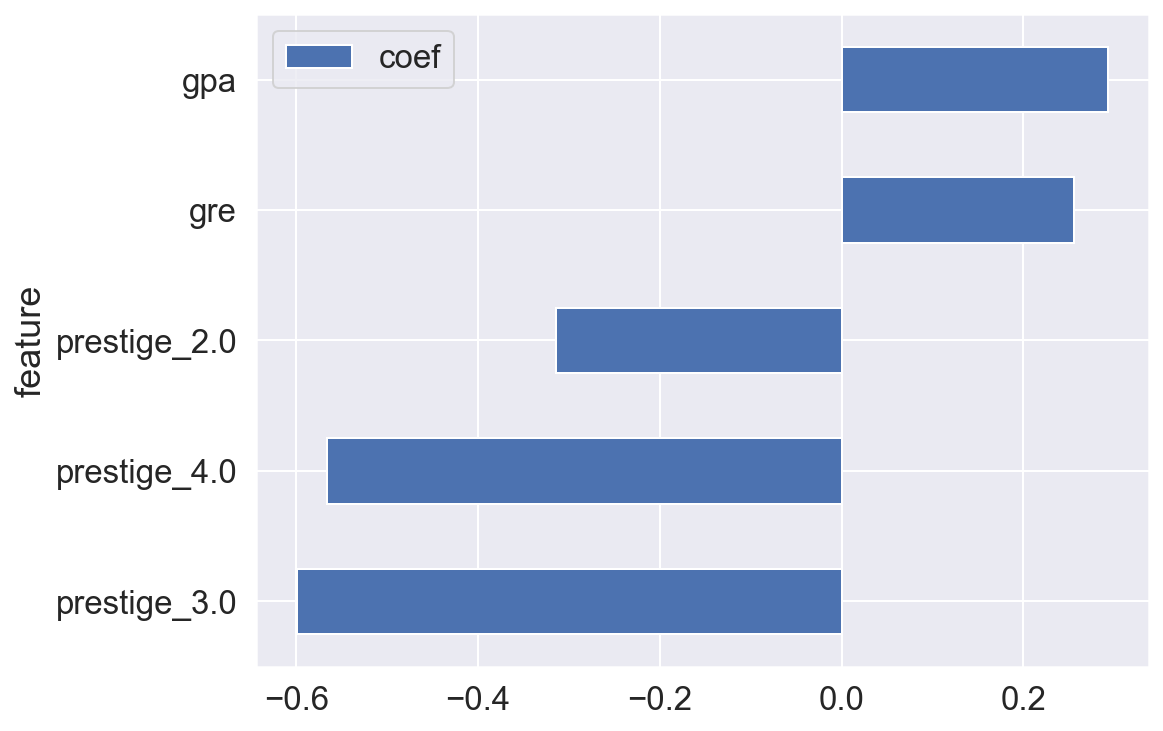

In [20]:
pd.DataFrame(list(zip(X.columns, model.coef_[0])), columns=['feature', 'coef']
            ).sort_values(by='coef'
                         ).plot(kind='barh', x='feature', y='coef', figsize=(8, 6))
plt.show()

In [21]:
model_cv = LogisticRegressionCV(Cs=np.logspace(-4, 4, 20), solver='liblinear', penalty='l1', cv=5)
model_cv.fit(X, y)
model_cv.score(X, y)

0.707808564231738

In [22]:
model = LogisticRegression(C=model_cv.C_[0], penalty='l1', solver='liblinear')
model.fit(X, y)
cross_val_score(model, X, y, cv=5).mean()

0.702766057196437

In [23]:
model.coef_

array([[ 0.25397005,  0.29307928, -0.3168866 , -0.60330907, -0.57002303]])

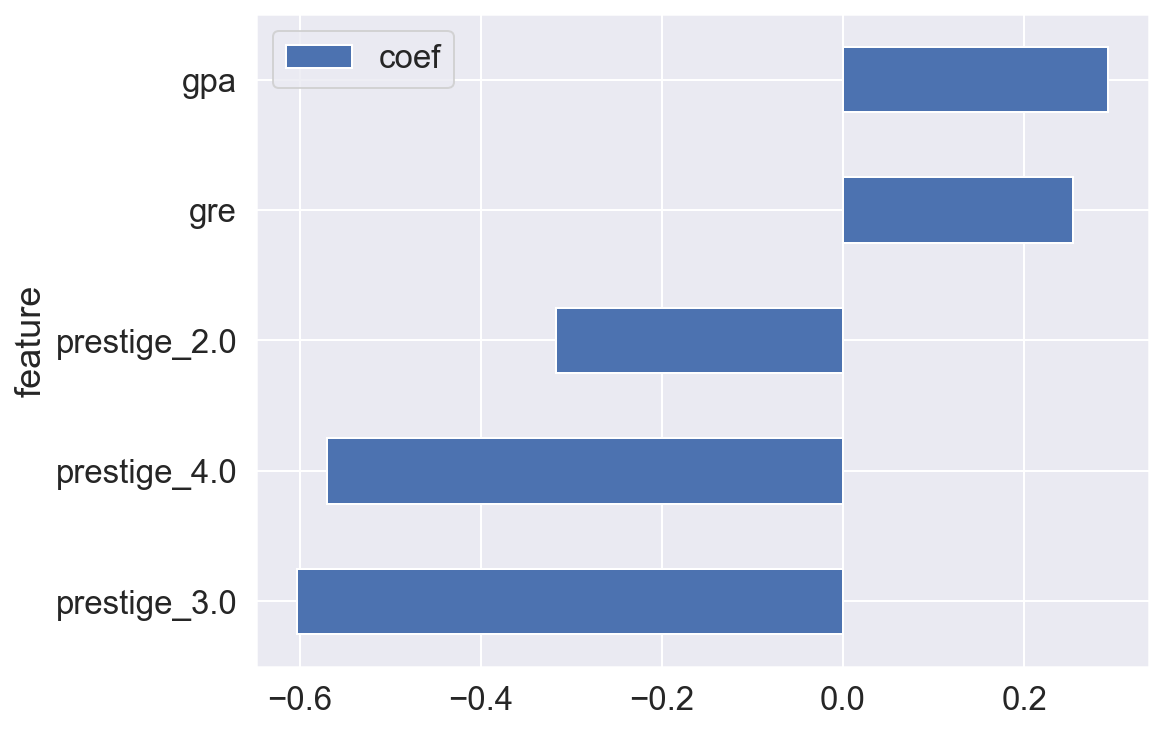

In [24]:
pd.DataFrame(list(zip(X.columns, model.coef_[0])), columns=['feature', 'coef']
            ).sort_values(by='coef'
                         ).plot(kind='barh', x='feature', y='coef', figsize=(8, 6))
plt.show()

### Compare to kNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
scores = []
for k in range(1, int(len(X)-np.ceil(len(X)/5))):
    model = KNeighborsClassifier(n_neighbors=k)
    scores.append((k, cross_val_score(model, X, y, cv=5).mean()))

In [27]:
sorted(scores, key=lambda x: x[1], reverse=True)[:10]

[(14, 0.7078293483356775),
 (12, 0.7053602125332084),
 (10, 0.7029535864978903),
 (16, 0.7028285669635881),
 (40, 0.7027035474292859),
 (53, 0.7027035474292859),
 (20, 0.7003594311611189),
 (32, 0.7002969213939678),
 (30, 0.7002344116268168),
 (41, 0.7001719018596655)]